In [99]:
import pandas as pd
import io
import re
import string
import seaborn as sns
import pickle

from cleantext import clean

import langdetect
from langdetect import detect

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score, recall_score

In [4]:
raw_df = pd.read_csv('Suicide_Detection.csv')

In [5]:
raw_df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


## Data Understanding and Wrangling

In [6]:
df = raw_df.drop(columns = ['Unnamed: 0'])
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [7]:
df.shape

(232074, 2)

In [8]:
df.describe()

,text,class
count,232074,232074
unique,232074,2
top,Ex Wife Threatening SuicideRecently I left my ...,suicide
freq,1,116037


keep only unique text

In [9]:
df = df.drop_duplicates()
df.describe()

,text,class
count,232074,232074
unique,232074,2
top,Ex Wife Threatening SuicideRecently I left my ...,suicide
freq,1,116037


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 5.3+ MB


no missing values

### check emoji

In [11]:
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [45]:
#remove emoji and other language
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [44]:
#text = "This sample text contains laughing emojis !!😇知道哦发 阿方索近来可好 ajlsfhd アイ・ラブ・ユー"
#remove_emoji(text)

'This sample text contains laughing emojis !!  ajlsfhd '

In [65]:
df['clean_text'] = df['text'].apply(lambda x: remove_emoji(x))

In [66]:
df.head()

,text,class,clean_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,Ex Wife Threatening SuicideRecently I left my ...
1,Am I weird I don't get affected by compliments...,non-suicide,Am I weird I don't get affected by compliments...
2,Finally 2020 is almost over... So I can never ...,non-suicide,Finally 2020 is almost over... So I can never ...
3,i need helpjust help me im crying so hard,suicide,i need helpjust help me im crying so hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,"I’m so lostHello, my name is Adam (16) and I’v..."


#### Remove digits, punctuation and keep lowercase -> only for english words

In [67]:
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

In [72]:
#Lowercase the text
df['clean_text']=df['clean_text'].apply(lambda x: x.lower())

In [75]:
df.describe()

,text,class,clean_text
count,232074,232074,232074
unique,232059,2,231922
top,it's so fucking hot it's so hot in my city. ri...,suicide,real suppleroot hours who up how has yo...
freq,2,116037,17


In [78]:
#keep only unique
df = df.drop(columns = 'text')
df = df.drop_duplicates()
df.describe()

,class,clean_text
count,231924,231924
unique,2,231922
top,suicide,
freq,116032,2


#### check language and keep only english

In [79]:
df.to_csv('suicide_after_text_preprocessing.csv')

## Exploratory Data Analysis (EDA)

In [80]:
stops = stopwords.words('english')

In [81]:
def remove_punc(string):
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
    for ele in string:  
        if ele in punc:  
            string = string.replace(ele, "") 
    return string
 
stop_words = [remove_punc(i) for i in stops]


In [82]:
stop_words.append('im')

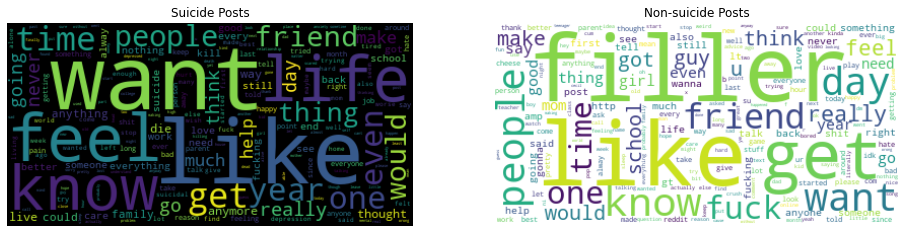

In [84]:
#check words related to suicide
fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_sui = " ".join(df['clean_text'][df['class'] == 'suicide'])
text_nonsui = " ".join(df['clean_text'][df['class'] == 'non-suicide'])
train_cloud_pos = WordCloud(collocations = False, background_color = 'black', stopwords = stop_words).generate(text_sui)
train_cloud_neg = WordCloud(collocations = False, background_color = 'white', stopwords = stop_words).generate(text_nonsui)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Suicide Posts')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Non-suicide Posts')

plt.show()

In [85]:
#check words in each review
df["Words per post"] = df["clean_text"].str.split().apply(len)
df["Words per post"].describe()

count    231924.000000
mean        136.650653
std         221.577608
min           0.000000
25%          27.000000
50%          63.000000
75%         161.000000
max        9685.000000
Name: Words per post, dtype: float64

In [86]:
#remove posts with lots of words
#tweet limit char is 280 
df2 = df[df['Words per post'] < 300]

In [87]:
df2.shape

(204964, 3)

In [88]:
df2.to_csv('wordlimit_suicide_after_text_preprocessing.csv')

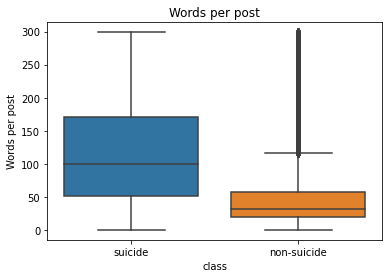

In [89]:
sns.boxplot(x="class", y="Words per post", data = df2)
plt.title('Words per post')
plt.show()

**EDA Conclusions**
- Posts with suicidal tendencies contain more words about life, time, opposition/rejection
- Posts with suicidal tendencies may have more words

## Text Preproessing and Modelling

<AxesSubplot:>

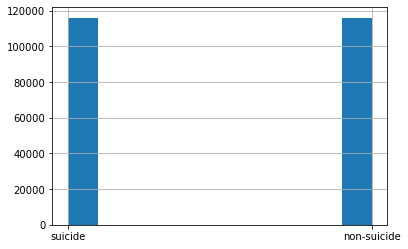

In [97]:
#check class balance
df['class'].hist()

In [90]:
inputs = df2['clean_text']
labels = pd.get_dummies(df2['class'])['suicide']

inputs_train, inputs_test, Ytrain, Ytest = train_test_split(inputs, labels, random_state = 157)

inputs_train.shape, inputs_test.shape

((153723,), (51241,))

In [91]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
    
class LemmaTokenizer:
    def __init__(self): 
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        words_and_tags = nltk.pos_tag(tokens)
        return [self.wnl.lemmatize(word, pos = get_wordnet_pos(tag)) for word, tag in words_and_tags]

In [92]:
vectorize = CountVectorizer(stop_words='english',tokenizer=LemmaTokenizer(),decode_error = 'ignore') 

In [93]:
Xtrain = vectorize.fit_transform(inputs_train)
Xtest = vectorize.transform(inputs_test)

Xtrain.shape,Xtest.shape

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  warnings.warn(


((153723, 91517), (51241, 91517))

In [112]:
model = MultinomialNB()
model.fit(Xtrain, Ytrain)

MultinomialNB()

In [113]:
modelname = 'NB_model.sav'
pickle.dump(model, open(modelname, 'wb'))

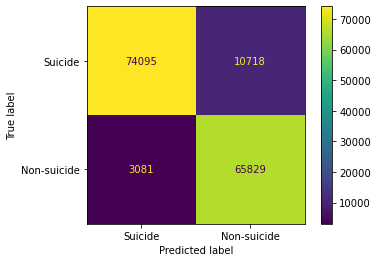

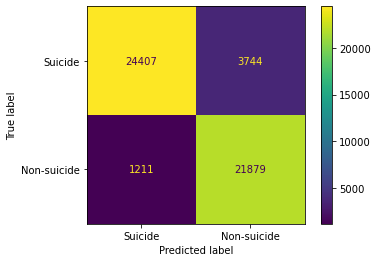

In [114]:
Ypred = model.predict(Xtest)
Ytrain_pred = model.predict(Xtrain)

cm_train = confusion_matrix(Ytrain, Ytrain_pred)
cm_display_train = ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = ['Suicide', 'Non-suicide'])
cm_display_train.plot()

cm_test = confusion_matrix(Ytest, Ypred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = ['Suicide', 'Non-suicide'])
cm_display.plot()

In [103]:
#acc
print('The accuracy of training data: ', accuracy_score(Ytrain, Ytrain_pred))
print('The accuracy of testing data: ', accuracy_score(Ytest, Ypred))

The accuracy of training data:  0.9102346428315867
The accuracy of testing data:  0.9033000917234246


In [115]:
#precision & recall
print('The precision of training data: ', precision_score(Ytrain, Ytrain_pred))
print('The precision of testing data: ', precision_score(Ytest, Ypred))

print('The recall of training data: ', recall_score(Ytrain, Ytrain_pred))
print('The recall of testing data: ', recall_score(Ytest, Ypred))

The precision of training data:  0.8599814493056553
The precision of testing data:  0.8538812785388128
The recall of training data:  0.9552895080539835
The recall of testing data:  0.9475530532698138


### Intrepret the model with weight

highly right_skewed

### Tweet API

In [116]:
wyoming = pd.read_csv('NEWWyomingJune22.csv')

In [117]:
wyoming.head()

,Unnamed: 0,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count
0,0,1348356904058290176,woodhull_abe,1487,8643,American | OIF / OEF Veteran | Anti-Globalist ...,NaN,The good thing about #Progressives is that the...,2022-06-30 23:38:56+00:00,0,0,2,0
1,1,1348356904058290176,woodhull_abe,1487,8643,American | OIF / OEF Veteran | Anti-Globalist ...,NaN,If the core of your political party is hyper f...,2022-06-30 23:22:58+00:00,0,0,0,0
2,2,1122913082332864512,UMFanAugdahl,3259,25883,Born and raised a diehard Michigan fan. GVSU g...,"Grand Rapids, MI",It’s a great day to enjoy some single-A baseball,2022-06-30 21:10:23+00:00,0,1,7,0
3,3,1122913082332864512,UMFanAugdahl,3259,25883,Born and raised a diehard Michigan fan. GVSU g...,"Grand Rapids, MI",Do not want Virginia in the B1G. I can’t stand...,2022-06-30 20:34:21+00:00,0,3,24,0
4,4,1122913082332864512,UMFanAugdahl,3259,25883,Born and raised a diehard Michigan fan. GVSU g...,"Grand Rapids, MI",Don’t like the B1G Title moving to SoFi Stadiu...,2022-06-30 20:26:08+00:00,0,16,40,0


In [150]:
wyoming_test = wyoming.drop(columns = 'Unnamed: 0')
wyoming_test.shape

(612, 13)

#### Text preprocessing

In [151]:
wyoming_test['clean_text'] = wyoming_test['text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

In [152]:
wyoming_test['clean_text']=wyoming_test['clean_text'].apply(lambda x: x.lower())

In [153]:
wyoming_test.head()

,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count,clean_text
0,1348356904058290176,woodhull_abe,1487,8643,American | OIF / OEF Veteran | Anti-Globalist ...,NaN,The good thing about #Progressives is that the...,2022-06-30 23:38:56+00:00,0,0,2,0,the good thing about progressives is that the...
1,1348356904058290176,woodhull_abe,1487,8643,American | OIF / OEF Veteran | Anti-Globalist ...,NaN,If the core of your political party is hyper f...,2022-06-30 23:22:58+00:00,0,0,0,0,if the core of your political party is hyper f...
2,1122913082332864512,UMFanAugdahl,3259,25883,Born and raised a diehard Michigan fan. GVSU g...,"Grand Rapids, MI",It’s a great day to enjoy some single-A baseball,2022-06-30 21:10:23+00:00,0,1,7,0,it s a great day to enjoy some single a baseball
3,1122913082332864512,UMFanAugdahl,3259,25883,Born and raised a diehard Michigan fan. GVSU g...,"Grand Rapids, MI",Do not want Virginia in the B1G. I can’t stand...,2022-06-30 20:34:21+00:00,0,3,24,0,do not want virginia in the b g i can t stand...
4,1122913082332864512,UMFanAugdahl,3259,25883,Born and raised a diehard Michigan fan. GVSU g...,"Grand Rapids, MI",Don’t like the B1G Title moving to SoFi Stadiu...,2022-06-30 20:26:08+00:00,0,16,40,0,don t like the b g title moving to sofi stadiu...


In [154]:
tweet = wyoming_test['clean_text']
tweet = vectorize.transform(tweet)

In [155]:
wyoming_test['label'] = model.predict(tweet)

In [156]:
wyoming_test['label'].value_counts()

0    475
1    137
Name: label, dtype: int64

In [157]:
flag = wyoming_test[wyoming_test['label'] == 1]
flag

,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count,clean_text,label
10,1122913082332864512,UMFanAugdahl,3259,25883,Born and raised a diehard Michigan fan. GVSU g...,"Grand Rapids, MI",Playoff expansion is inevitable at this point,2022-06-30 18:00:31+00:00,0,0,3,0,playoff expansion is inevitable at this point,1
12,1032136902294560768,emilyp2421,106,3710,21 🌸 i’m just here bro,NaN,I DONT WANT TO GO HOME ☹️☹️☹️☹️☹️☹️☹️☹️,2022-06-30 16:38:30+00:00,0,0,0,1,i dont want to go home,1
22,1032136902294560768,emilyp2421,106,3710,21 🌸 i’m just here bro,NaN,time goes by too quickly here 🥺,2022-06-30 03:09:47+00:00,0,0,1,0,time goes by too quickly here,1
23,881529859,madiidale,1087,12573,"i have no fear, i have only love • she/her","Sioux Falls, SD",i’m pretty good at drinkin beer,2022-06-30 00:21:06+00:00,1,1,14,0,i m pretty good at drinkin beer,1
38,474068285,CallMe_PRETTYC,1474,84699,Sc-Callme_prettyc,NaN,"I miss being laid up so much, this sleeping al...",2022-06-29 03:43:19+00:00,0,0,0,0,i miss being laid up so much this sleeping al...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,2577919497,iAmErikGonzalez,270,13533,Chances Make Champions. Freedom 25.,"Grand Rapids, MI",Yeah banning ARs is gonna stop a tranny that h...,2022-06-02 23:51:58+00:00,0,1,0,0,yeah banning ars is gonna stop a tranny that h...,1
583,347909007,LookAtTEDDIE,3664,18510,|Father Of Cairo D. Eddie🦁|Louisianimal🦍|Cance...,Da Boot🐊,On way is 🆙,2022-06-02 21:21:45+00:00,0,0,0,0,on way is,1
593,474068285,CallMe_PRETTYC,1474,84699,Sc-Callme_prettyc,NaN,I just want to lay up,2022-06-02 01:00:34+00:00,0,0,0,0,i just want to lay up,1
601,1474896524375117828,MicaelaSkyy,36,1251,"Trucker by trade, Creative Director by heart |...","Maryland, USA",Why would you live your whole life trying to g...,2022-06-01 12:05:38+00:00,0,0,0,0,why would you live your whole life trying to g...,1


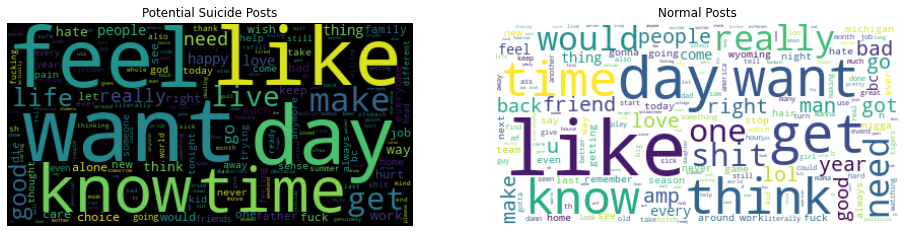

In [139]:
#check the words
fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_sui = " ".join(wyoming_test['clean_text'][wyoming_test['label'] == 1])
text_nonsui = " ".join(wyoming_test['clean_text'][wyoming_test['label'] == 0])
train_cloud_pos = WordCloud(collocations = False, background_color = 'black', stopwords = stop_words).generate(text_sui)
train_cloud_neg = WordCloud(collocations = False, background_color = 'white', stopwords = stop_words).generate(text_nonsui)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Potential Suicide Posts')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Normal Posts')

plt.show()

#### Check the probability

In [158]:
wyoming_test['prob'] = model.predict_proba(tweet)[:,1]

In [159]:
wyoming_test.head()

,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count,clean_text,label,prob
0,1348356904058290176,woodhull_abe,1487,8643,American | OIF / OEF Veteran | Anti-Globalist ...,NaN,The good thing about #Progressives is that the...,2022-06-30 23:38:56+00:00,0,0,2,0,the good thing about progressives is that the...,0,0.466593
1,1348356904058290176,woodhull_abe,1487,8643,American | OIF / OEF Veteran | Anti-Globalist ...,NaN,If the core of your political party is hyper f...,2022-06-30 23:22:58+00:00,0,0,0,0,if the core of your political party is hyper f...,0,0.000962
2,1122913082332864512,UMFanAugdahl,3259,25883,Born and raised a diehard Michigan fan. GVSU g...,"Grand Rapids, MI",It’s a great day to enjoy some single-A baseball,2022-06-30 21:10:23+00:00,0,1,7,0,it s a great day to enjoy some single a baseball,0,0.179687
3,1122913082332864512,UMFanAugdahl,3259,25883,Born and raised a diehard Michigan fan. GVSU g...,"Grand Rapids, MI",Do not want Virginia in the B1G. I can’t stand...,2022-06-30 20:34:21+00:00,0,3,24,0,do not want virginia in the b g i can t stand...,0,0.000068
4,1122913082332864512,UMFanAugdahl,3259,25883,Born and raised a diehard Michigan fan. GVSU g...,"Grand Rapids, MI",Don’t like the B1G Title moving to SoFi Stadiu...,2022-06-30 20:26:08+00:00,0,16,40,0,don t like the b g title moving to sofi stadiu...,0,0.000118


In [166]:
#check for top 10 contents
pd.set_option('max_colwidth', 300)
wyoming_test.sort_values('prob', ascending=False)[['username','text']].head(10)

,username,text
351,BrendonMinchew,"WHY did I move far away from home to avoid actually killing myself, just for my friends here to start killing themselves? I don’t want to do this anymore."
339,elliewilhelm,"literally down the hall, and within the same system, and I’m just very busy. I’ve also been a patient of hers for 5 years. Can you really not cut me any slack? Fill my med before I come in? This just feels like an unnecessary barrier. And I didn’t know she wouldn’t refill 2/"
112,IamAndreaW,"Though it was never anything I kept a secret, just something I never publicized….until now at age 33.\n\nI also know I am not changing for anyone, and if you feel the same way, you shouldn't either. We should all be able to live our truth, love who we want, want who we want,"
111,IamAndreaW,"and be who we want. More than anything, that's why I am doing this. I can't run from the truth anymore and the fact is, I shouldn't have to. So I won't, not anymore, not ever again."
340,elliewilhelm,"Ok I’m sure it’s best practice but my PCP won’t refill my antidepressant that I’ve been taking for 7 years, until I come into the office. I work full time +, and have two kids. She can clearly see my Gyn appointments, vitals, and BMP from March in the office adjacent 1/"
601,MicaelaSkyy,"Why would you live your whole life trying to get to Heaven, but live your whole life in Hell?"
65,sidneey_breanna,These past couple of days with my family have been truly amazing I missed them 😭❤️ it sucks they live all the way over here but I’m grateful when I do see them 💗
88,carsonkunnen,"“I have been crucified with Christ. It is no longer I who live, but Christ who lives in me. And the life I now live in the flesh I live by faith in the Son of God, who loved me and gave himself for me.”\n—Galatians 2:20"
73,sarah__graceee,"To have a CHOICE taken from you is the injustice. I made my choice and I don’t regret it a single bit. However, that CHOICE is still a choice I was allowed to make and I think everyone should be free to make their own choices."
76,grimydiva,I get genuinely triggered when people try to rush summer away. It’s the only season I don’t want to actively die


#### suicide risk stratification

In [167]:
wyoming_test['prob'].describe()

count    6.120000e+02
mean     2.544875e-01
std      3.235325e-01
min      3.255068e-11
25%      4.520966e-03
50%      7.491134e-02
75%      4.555780e-01
max      9.999503e-01
Name: prob, dtype: float64

In [220]:
bins= [0, 0.5, 0.7, 0.9, 1]
labels = ['None', 'Low Risk', 'Moderate Risk', 'High Risk']

wyoming_test['Suicide Risk Stratification'] = pd.cut(wyoming_test['prob'], 
                                                     bins, 
                                                     labels = labels, 
                                                     include_lowest = True)

In [221]:
wyoming_test.to_csv('wyoming_suicide_risk.csv')

#### Suicide Risk for Person (based on Username)

In [222]:
risk = pd.DataFrame(wyoming_test.groupby('username')['prob'].mean().reset_index())
risk.head()

,username,prob
0,12newshoe,0.008295
1,1bstrong,0.971860
2,3bitchesandagay,0.086367
3,AbbieNicholas2,0.981349
4,AlexisAlario,0.198659


In [223]:
bins= [0, 0.5, 0.7, 0.9, 1]
labels = ['None', 'Low Risk', 'Moderate Risk', 'High Risk']

risk['Suicide Risk Stratification'] = pd.cut(risk['prob'], 
                                                     bins, 
                                                     labels = labels, 
                                                     include_lowest = True)

In [231]:
risk_group = risk.groupby('Suicide Risk Stratification')['prob'].count().reset_index()
risk_group.rename(columns = {'prob':'Count'}, inplace=True)
risk_group

,Suicide Risk Stratification,Count
0,None,132
1,Low Risk,9
2,Moderate Risk,11
3,High Risk,15


<AxesSubplot:xlabel='Count', ylabel='Suicide Risk Stratification'>

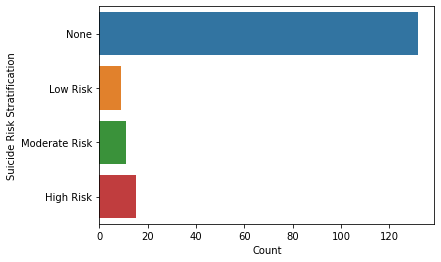

In [232]:
sns.barplot(x = 'Count', y = 'Suicide Risk Stratification', data = risk_group)